In [72]:
### 分析有哪些loop的锚点区包含基因
import pandas as pd
def gene_loop(l1, df1, l2, df2):
    df_result = pd.DataFrame(columns = ['c1', 's1', 'e1', 't1', 'g1', 'c2', 's2', 'e2', 't2', 'g2'])
    if df1.shape[0] == 0:
        geneid1 = ['nogene']
    else:
        geneid1 = df1['gid'].tolist()
    if df2.shape[0] == 0:
        geneid2 = ['nogene']
    else:
        geneid2 = df2['gid'].tolist()
    #print(geneid1, geneid2)
    for g1 in geneid1:
        for g2 in geneid2:
            gene_loop_list = l1 + [g1] + l2 + [g2]
            df_result.loc[df_result.shape[0], :] = gene_loop_list
    #print(df_result)
    return df_result

df_loop = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop_new/intra_loop_10_0005_bin_gtags.txt', sep='\t', names=['c1', 's1', 'e1', 'c2', 's2', 'e2', 't1', 't2'])
#df_loop = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop_new/test.txt', sep='\t', names=['c1', 's1', 'e1', 'c2', 's2', 'e2', 't1', 't2'])
df_gene = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/TM-1_allgene_promoter_FPKM.txt', sep='\t', names=['c', 's', 'e', 'gid', 'fpkm'])
chrs = ['Ghir_A01', 'Ghir_A02', 'Ghir_A03', 'Ghir_A04', 'Ghir_A05', 'Ghir_A06', 'Ghir_A07', 'Ghir_A08', 'Ghir_A09', 'Ghir_A10', 'Ghir_A11', 'Ghir_A12', 'Ghir_A13', 'Ghir_D01', 'Ghir_D02', 'Ghir_D03', 'Ghir_D04', 'Ghir_D05', 'Ghir_D06', 'Ghir_D07', 'Ghir_D08', 'Ghir_D09', 'Ghir_D10', 'Ghir_D11', 'Ghir_D12', 'Ghir_D13']
df_result = pd.DataFrame()
for cs in chrs:
    df_loop_chr = df_loop.query("c1==@cs").copy()
    df_gene_chr = df_gene.query("c==@cs").copy()
    for index, row in df_loop_chr.iterrows():
        c1, s1, e1, c2, s2, e2, t1, t2 = row['c1'], row['s1'], row['e1'], row['c2'], row['s2'], row['e2'], row['t1'], row['t2']
        df_tmp1 = df_gene.query("c==@c1 & s<=@e1 & e>=@s1").copy()
        df_tmp2 = df_gene.query("c==@c2 & s<=@e2 & e>=@s2").copy()
        #print(df_tmp1)
        #print(df_tmp2)
        l1 = [c1, s1, e1, t1]
        l2 = [c2, s2, e2, t2]
        df_tmp = gene_loop(l1, df_tmp1, l2, df_tmp2)
        if df_result.shape[0] == 0:
            df_result = df_tmp
        else:
            df_result = df_result.append(df_tmp, ignore_index=True)
df_result.to_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop_new/all_loop_geneid.txt', sep='\t', index=False)


In [73]:
## 给基因id 添加上表达量标签
df_fpkm = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/TM-1_allgene_FPKM.txt', sep='\t')
df_loop = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop_new/all_loop_geneid.txt', sep='\t')
df_id_fpkm = df_fpkm[['Geneid', 'FPKM']].copy()
df_id_fpkm.columns = ['g1', 'fpkm1']
df_geneid = pd.merge(df_loop, df_id_fpkm, how='left', on='g1')
df_id_fpkm.columns = ['g2', 'fpkm2']
df_geneid = pd.merge(df_geneid, df_id_fpkm, how='left', on='g2')
df_geneid.to_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop_new/all_loop_geneid_fpkm.txt', sep='\t', index=False)

In [78]:
## 将loop 整理为前面是非基因区域，后面是基因区域格式
import pandas as pd
def nogene_gene(df):
    df_GN = df.query("(t1=='G' & t2=='N') | (t1=='N' & t2=='G')").copy()
    #print(df_GN)
    df_result = pd.DataFrame(columns=['c', 's', 'e', 'gid', 'FPKM'])
    for index, row in df_GN.iterrows():
        c1, s1, e1, c2, s2, e2, gid1, gid2, fpkm1, fpkm2 = row['c1'], row['s1'], row['e1'], row['c2'], row['s2'], row['e2'], row['g1'], row['g2'], row['fpkm1'], row['fpkm2']
        #print(gid1, gid2)
        if gid1 == "nogene":
            df_result.loc[df_result.shape[0], :] = [c1, s1, e1, gid2, fpkm2]
        else:
            df_result.loc[df_result.shape[0], :] = [c2, s2, e2, gid1, fpkm1]
    #print(df_result)
    return df_result
df = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop_new/all_loop_geneid_fpkm.txt', sep='\t')
df_result = nogene_gene(df)
df_result.to_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop_new/all_nogene_genes_loop.txt', sep='\t', index=False, header=False)  

In [ ]:
## 分析bias 基因有多少具有loop分布差异
import pandas as pd
df_gene = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/all_bias_expression.txt', sep='\t')
df_loop_anchors = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/intra_loopanchors_10_0005_bin.txt', sep='\t', names = ['chr', 'start', 'end'])
df_gene['at_s'] = df_gene['Start_at'] - 3000
df_gene['at_e'] = df_gene['End_at'] + 500
df_gene['dt_s'] = df_gene['Start_dt'] - 3000
df_gene['dt_e'] = df_gene['End_dt'] + 500
for index, row in df_gene.iterrows():
    chr_at, start_at, end_at, chr_dt, start_dt, end_dt = row['Chr_at'], row['at_s'], row['at_e'], row['Chr_dt'], row['dt_s'], row['dt_e']
    #print(chr_at, start_at, end_at)
    loop_anchors_number_at = df_loop_anchors.query('chr==@chr_at & start <= @end_at & end >= @start_at').shape[0]
    #print(df_loop_anchors.query('chr==@chr_at & start <= @end_at & end >= @start_at'))
    #print(loop_anchors_number_at)
    loop_anchors_number_dt = df_loop_anchors.query('chr==@chr_dt & start <= @end_dt & end >= @start_dt').shape[0]
    df_gene.loc[index, 'at_anchor'] = loop_anchors_number_at
    df_gene.loc[index, 'dt_anchor'] = loop_anchors_number_dt
df_gene['At_Dt_anchor'] = df_gene['at_anchor'] - df_gene['dt_anchor']
df_bias = df_gene.query("(Bias=='biasA' & At_Dt_anchor>0) | (Bias=='biasD' & At_Dt_anchor<0)").copy()
df_bias.to_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/loop/gene_bias_loop_bias.txt', sep='\t', index=False)


In [4]:
## 分析bias基因同时满足loop 差异的同源基因对在chip修饰水平上的差异
import pandas as pd
df = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/loop/gene_loop_bias_tags.txt', sep='\t')
df_h3k4me3 = pd.read_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/TM1_H3K4me3_Rep3_peaks.narrowPeak', sep='\t', names=['chr', 'start', 'end'])
df_h3k27ac = pd.read_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/TM1_H3K27ac_Rep1_peaks.narrowPeak', sep='\t', names=['chr', 'start', 'end'])
#df_h3k27ac = pd.read_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/TM1_H3K9ac_Rep1_peaks.narrowPeak', sep='\t', names=['chr', 'start', 'end'])
## h3k4me3
for index, row in df.iterrows():
    at_c, at_s, at_e = row['Chr_at'], row['at_s'], row['at_e']
    dt_c, dt_s, dt_e = row['Chr_dt'], row['dt_s'], row['dt_e']
    df_at_tmp = df_h3k4me3.query("chr==@at_c & start <= @at_e & end >= @at_s")
    df_dt_tmp = df_h3k4me3.query("chr==@dt_c & start <= @dt_e & end >= @dt_s")
    if df_at_tmp.shape[0]:
        df.loc[index, 'at_k4me3'] = 'Y'
    else:
        df.loc[index, 'at_k4me3'] = 'N'
    if df_dt_tmp.shape[0]:
        df.loc[index, 'dt_k4me3']  = 'Y'
    else:
        df.loc[index, 'dt_k4me3'] = 'N'
## h3k27ac
for index, row in df.iterrows():
    at_c, at_s, at_e = row['Chr_at'], row['at_s'], row['at_e']
    dt_c, dt_s, dt_e = row['Chr_dt'], row['dt_s'], row['dt_e']
    df_at_tmp = df_h3k27ac.query("chr==@at_c & start <= @at_e & end >= @at_s")
    df_dt_tmp = df_h3k27ac.query("chr==@dt_c & start <= @dt_e & end >= @dt_s")
    if df_at_tmp.shape[0]:
        df.loc[index, 'at_k27ac'] = 'Y'
    else:
        df.loc[index, 'at_k27ac'] = 'N'
    if df_dt_tmp.shape[0]:
        df.loc[index, 'dt_k27ac']  = 'Y'
    else:
        df.loc[index, 'dt_k27ac'] = 'N'
## h3k9me2
df.to_csv("F:/TM-1_leaf_3D-genome/RNA_Seq/bias/chip/bias_gene_loop_H3k4me3_H3k27ac.txt", sep='\t', index=False)

In [10]:
## 筛选符合要求的同源基因对，符合要求指，BiasA，At的loop更多，同时At有H3K4me3和H3K27ac的修饰
import pandas as pd
df = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/chip/bias_gene_loop_H3k4me3_H3k27ac.txt', sep='\t')
df_out = df.query("(At_Dt_anchor<0 & dt_k27ac =='Y' & dt_k4me3=='Y' & at_k27ac=='N' & at_k4me3=='N')| (At_Dt_anchor>0 & at_k27ac =='Y' & at_k4me3=='Y' & dt_k27ac =='N' & dt_k4me3=='N')")
df_out.to_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/chip/bias_gene_loop_H3k4me3_H3k27ac_needed.txt', sep='\t', index=False)

In [15]:
## 将所有符合要求的同源基因对，写成能够作图的样子，并作图
import pandas as pd
df = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/chip/bias_gene_loop_H3k4me3_H3k27ac_needed.txt', sep='\t')
fp = open("F:/TM-1_leaf_3D-genome/RNA_Seq/bias/chip/figure/plot_all_homo_gene.sh", 'w')
for index, row in df.iterrows():
    at_chr, dt_chr, at_s, at_e, dt_s, dt_e, at_id = row['Chr_at'], row['Chr_dt'], row['at_s'], row['at_e'], row['dt_s'], row['dt_e'], row['Geneid_at']
    at_s, at_e, dt_s, dt_e = at_s - 100000, at_e + 100000, dt_s - 100000, dt_e + 100000
    #line_at = "bsub -q high -e %J.err -o %J.out -R span[hosts=1] -J {3} 'pyGenomeTracks --tracks loop.ini --region {0}:{1}-{2} -o figure/{3}_at.pdf'".format(at_chr, at_s, at_e, at_id)
    #line_dt = "bsub -q high -e %J.err -o %J.out -R span[hosts=1] -J {3} 'pyGenomeTracks --tracks loop.ini --region {0}:{1}-{2} -o figure/{3}_dt.pdf'".format(dt_chr, dt_s, dt_e, at_id)
    line_at = "bsub -q high -e %J.err -o %J.out -R span[hosts=1] -J {3} 'sh plot_loop.sh {0} {1} {2} figure/{3}_at.pdf'".format(at_chr, at_s, at_e, at_id)
    line_dt = "bsub -q high -e %J.err -o %J.out -R span[hosts=1] -J {3} 'sh plot_loop.sh {0} {1} {2} figure/{3}_dt.pdf'".format(dt_chr, dt_s, dt_e, at_id)
    print(line_at, file = fp)
    print(line_dt, file = fp)
fp.close()


In [16]:
## 分析At亚组和Dt亚组的同源区段（同源基因）
import pandas as pd
df = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/intra_loop_10_0005_bin.txt', sep='\t', names=['c1', 's1', 'e1', 'c2', 's2', 'e2'])
chrs, start, end = 'Ghir_A03', 4158885, 4165791 ## loop example Ghir_A03G002720
#chrs, start, end = 'Ghir_A03', 19480000, 19860000   ## TAD example
df_result = df.query("(c1==@chrs & s1<=@end & e1>=@start) | (c2==@chrs & s2<=@end & e2>=@start)")
print(df_result)
min_position = min(df_result[['s1', 'e1', 's2', 'e2']].min().tolist())
max_position = max(df_result[['s1', 'e1', 's2', 'e2']].max().tolist())
print(min_position, max_position)
df_gene_pairs = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/all_hg_expression.txt', sep='\t')
genes = df_gene_pairs.query("Chr_at==@chrs & Start_at<=@max_position & End_at >= @min_position")[['Geneid_at', 'Start_at', 'End_at', 'Geneid_dt', 'Start_dt', 'End_dt']]
print(genes)

             c1       s1       e1        c2       s2       e2
11012  Ghir_A03  4100000  4105000  Ghir_A03  4160000  4165000
11028  Ghir_A03  4160000  4165000  Ghir_A03  4225000  4230000
11029  Ghir_A03  4160000  4165000  Ghir_A03  4230000  4235000
11030  Ghir_A03  4160000  4165000  Ghir_A03  4325000  4330000
11031  Ghir_A03  4165000  4170000  Ghir_A03  4225000  4230000
11032  Ghir_A03  4165000  4170000  Ghir_A03  4240000  4245000
11033  Ghir_A03  4165000  4170000  Ghir_A03  4255000  4260000
11034  Ghir_A03  4165000  4170000  Ghir_A03  4295000  4300000
11035  Ghir_A03  4165000  4170000  Ghir_A03  4300000  4305000
4100000 4330000
            Geneid_at  Start_at   End_at        Geneid_dt  Start_dt    End_dt
3269  Ghir_A03G002690   4096356  4100534  Ghir_D03G016310  49072934  49077153
3270  Ghir_A03G002700   4103517  4106328  Ghir_D03G016300  49063622  49064188
3271  Ghir_A03G002720   4161885  4165291  Ghir_D03G016280  49047132  49050437
3272  Ghir_A03G002730   4176018  4176221  Ghir_D03G0

In [161]:
## 给同源基因打上染色体对的标签
import pandas as pd
import re
import seaborn as sns
import numpy as np
pattern = re.compile(r'\d+')
df = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/loop/gene_bias_loop_bias.txt', sep='\t')
for index, row in df.iterrows():
    at_chr, dt_chr = row['Chr_at'], row['Chr_dt']
    at_N, dt_N = pattern.findall(at_chr), pattern.findall(dt_chr)
    if at_N == dt_N:
        df.loc[index, 'tags'] = 'Homo_chr'
    else:
        df.loc[index, 'tags'] = 'NonHomo_chr'
df.fillna(0, inplace=True)
print(df.groupby('tags', as_index=False)['Chr_at'].count())
df['log2FC'] = df['FC'].apply(np.log2)
df.to_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/loop/gene_loop_bias_tags.txt', sep='\t', index=False)

          tags  Chr_at
0     Homo_chr     932
1  NonHomo_chr     181


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

biasD_Homo_chr vs. biasD_NonHomo_chr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.249e-03 U_stat=1.237e+04
biasA_Homo_chr vs. biasA_NonHomo_chr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.660e-02 U_stat=3.114e+04


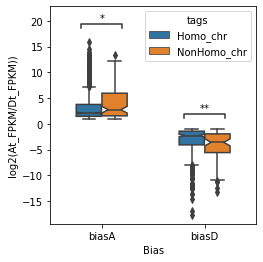

In [160]:
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
plt.xlim(-15, 15)
#plt.figure(figsize=(4,3))
ax = sns.boxplot(x="Bias", y="log2FC",hue="tags", data=df,order=['biasA', 'biasD'], width=0.5, notch=True)
ax.set_ylabel("log2(At_FPKM/Dt_FPKM))")
ax.set_aspect(0.05)
#ax = sns.violinplot(x="Bias", y="log2FC",hue="tags", data=df)
box_pairs = [(('biasA', 'Homo_chr'), ('biasA', 'NonHomo_chr')),
         (('biasD', 'Homo_chr'), ('biasD', 'NonHomo_chr'))]
annotator = Annotator(ax, pairs=box_pairs, data=df, x="Bias", y="log2FC", hue="tags", order=['biasA', 'biasD'])
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
scatter_fig = ax.get_figure()
scatter_fig.savefig("F:/TM-1_leaf_3D-genome/RNA_Seq/bias/loop/chr_homogene.pdf")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

biasD_Y vs. biasD_N: Mann-Whitney-Wilcoxon test two-sided, P_val:5.416e-02 U_stat=1.148e+04
biasA_Y vs. biasA_N: Mann-Whitney-Wilcoxon test two-sided, P_val:1.002e-01 U_stat=3.247e+04


(<matplotlib.axes._subplots.AxesSubplot at 0x2ab9df0a850>,
  <statannotations.Annotation.Annotation at 0x2ab9df0a2b0>])

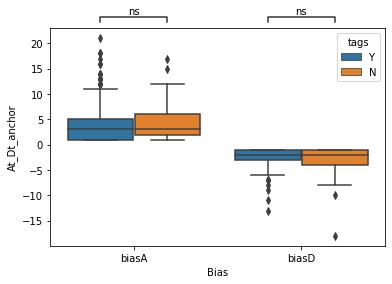

In [68]:
ax = sns.boxplot(x='Bias', y='At_Dt_anchor', hue="tags", data=df)
#plt.ylim(-20, 20)
annotator = Annotator(ax, pairs=box_pairs, data=df, x="Bias", y="At_Dt_anchor", hue="tags")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [56]:
df = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/all_hg_expression.txt', sep='\t')
def YN(dataf):
    pattern = re.compile(r'\d+')
    YN_data = []
    for index, row in dataf.iterrows():
        at_chr, dt_chr = row['Chr_at'], row['Chr_dt']
        at_N, dt_N = pattern.findall(at_chr), pattern.findall(dt_chr)
        if at_N == dt_N:
            YN_data.append('Y')
        else:
            YN_data.append('N')
    return YN_data
df['tags'] = YN(df)
print(df.groupby('tags', as_index=False)['Chr_at'].count())

  tags  Chr_at
0    N    3673
1    Y   21211


In [169]:
## 将loop转换为arcs格式
import pandas as pd
df_loop = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/intra_loop_10_0005_bin.txt', sep='\t', names=['chr1', 's1', 'e1', 'chr2', 's2', 'e2'])
df_loop['c1'] = df_loop['s1'] + 2500
df_loop['c11'] = df_loop['c1'] + 1
df_loop['c2'] = df_loop['s2'] + 2500
df_loop['c22'] = df_loop['c2'] + 1
df_loop['tags'] = [1]*df_loop.shape[0]
df_loop.to_csv('F:/TM-1_leaf_3D-genome/HiC/loop/intra_loop_10_0005_bin.arcs', sep='\t', columns=['chr1', 'c1', 'c11', 'chr2', 'c2', 'c22', 'tags'], header=False, index=False)

In [3]:
## 将loop 整理为前面是非基因区域，后面是基因区域格式
import pandas as pd
def nogene_gene(df):
    df_intra = df.query("tags == 'intra' & sig == 'GN'").copy()
    df_result = pd.DataFrame(columns=['c', 's', 'e', 'gid', 'FPKM'])
    for index, row in df_intra.iterrows():
        c1, s1, e1, c2, s2, e2, gid1, gid2, fpkm1, fpkm2 = row['Chr_s'], row['S_s'], row['S_e'], row['Chr_e'], row['E_s'], row['E_e'], row['Geneid_s'], row['Geneid_e'], row['FPKM_s'], row['FPKM_e']
        if gid1 == "not-gene":
            df_result.loc[df_result.shape[0], :] = [c1, s1, e1, gid2, fpkm2]
        else:
            df_result.loc[df_result.shape[0], :] = [c2, s2, e2, gid1, fpkm1]
    #print(df_result)
    return df_result
df = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop/all_loop_genes_interaction_tags.txt', sep='\t')
df_result = nogene_gene(df)
df_result.to_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop/all_nogene_genes_loop.txt', sep='\t', index=False, header=False)  

In [17]:
## 给非编码区打上chip的标签
import pandas as pd
def peaks_expansion(df, size):
    df['s2'] = df['s'] - size
    df['e2'] = df['e'] + size
    df_result = df[['c', 's2', 'e2', 'tags']].copy()
    df_result.columns = ['c', 's', 'e', 'tags']
    return df_result
def peaks_id(df):
    all_peaks = []
    for index, row in df.iterrows():
        peaks     = row['tags'].split('_')
        all_peaks = all_peaks + peaks
    result_peaks = "_".join(sorted(list(set(all_peaks)))) 
    #print(result_peaks) 
    return result_peaks 
def nogene_peaks(df_nogene, df_peaks):
    df_result = pd.DataFrame(columns = ['c', 's', 'e', 'gid', 'fpkm', 'peaks'])
    chrs = ['Ghir_A01', 'Ghir_A02', 'Ghir_A03', 'Ghir_A04', 'Ghir_A05', 'Ghir_A06', 'Ghir_A07', 'Ghir_A08', 'Ghir_A09', 'Ghir_A10', 'Ghir_A11', 'Ghir_A12', 'Ghir_A13', 'Ghir_D01', 'Ghir_D02', 'Ghir_D03', 'Ghir_D04', 'Ghir_D05', 'Ghir_D06', 'Ghir_D07', 'Ghir_D08', 'Ghir_D09', 'Ghir_D10', 'Ghir_D11', 'Ghir_D12', 'Ghir_D13']
    for cs in chrs:
        df_nogene_chr = df_nogene.query('c == @cs').copy()
        df_peaks_chr  = df_peaks.query('c == @cs').copy()
        for index, row in df_nogene_chr.iterrows():
            c, s, e, gid, fpkm = row['c'], row['s'], row['e'], row['gid'], row['fpkm']
            df_tmp = df_peaks_chr.query('c == @c & s <= @e & e >= @e')
            if df_tmp.shape[0] > 0:
                peaks_tag = peaks_id(df_tmp)
                #print(peaks_tag)
                #print(df_tmp)
                #print([c, s, e, gid, fpkm, peaks_tag])
                df_result.loc[df_result.shape[0], :] = [c, s, e, gid, fpkm, peaks_tag]
            else:
                df_result.loc[df_result.shape[0], :] = [c, s, e, gid, fpkm, "non_peaks"]
    return df_result
#df_nogene = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop/all_nogene_genes_loop.txt', sep='\t', names = ['c', 's', 'e', 'gid', 'fpkm']) 
df_nogene = pd.read_csv('F:/TM-1_leaf_3D-genome/HiC/loop/gene_loop_new/all_nogene_genes_loop.txt', sep='\t', names = ['c', 's', 'e', 'gid', 'fpkm']) 
df_peaks = pd.read_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/all_peaks_enhancer.txt', sep='\t', names=['c', 's', 'e', 'tags'])
#!* peaks 左右扩张2kb
df_peaks_2k = peaks_expansion(df_peaks, 2000) 
#df_result = nogene_peaks(df_nogene, df_peaks)
df_result = nogene_peaks(df_nogene, df_peaks_2k)
#print(df_result)
## 修改列标签
df_need = df_result.query("peaks != 'non_peaks'").copy()
df_need['tags'] = df_need['peaks'].apply(lambda x: "atac_active" if ("atac" in x and "k27me3" not in x) else ( "atac_inactive" if ("atac" in x and "k27me3" in x) else ("active" if ("atac" not in x and "k27me3" not in x) else "inactive")))
#df_need['tags'] = df_need['peaks'].apply(lambda x: "atac_inactive" if (x == "atac_k27me3") else ( "atac_active" if ("atac" in x and "k27me3" not in x) else ("inactive" if (x == "k27me3" ) else "active")))
#df_need.to_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/gene_enhancer_regulation_promoter.txt', sep='\t', index=False)
df_need.to_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/gene_enhancer_regulation_promoter_2k.txt', sep='\t', index=False)

In [18]:
print(df_need.groupby(by=['tags']).count())

                  c     s     e   gid  fpkm  peaks
tags                                              
active          930   930   930   930   930    930
atac_active    2397  2397  2397  2397  2397   2397
atac_inactive   806   806   806   806   806    806
inactive       4259  4259  4259  4259  4259   4259


In [19]:
## 分析同源基因对之间在非基因区域 loop修饰情况的差异
import pandas as pd
df_loop = pd.read_csv("F:/TM-1_leaf_3D-genome/ChIP/peaks/gene_enhancer_regulation_promoter_2k.txt", sep="\t")
df_hg = pd.read_csv("F:/TM-1_leaf_3D-genome/RNA_Seq/all_homo_gene_pairs_position.txt", sep="\t")
for index, row in df_hg.iterrows():
    at_gid, dt_gid = row['geneid_at'], row['geneid_dt']
    df_tmp_at = df_loop.query("gid == @at_gid")
    df_tmp_dt = df_loop.query("gid == @dt_gid")
    if df_tmp_at.shape[0]:
        df_hg.loc[index, "at_tags"] = df_tmp_at['peaks'].tolist()[0]
    else:
        df_hg.loc[index, "at_tags"] = 'zero'
    if df_tmp_dt.shape[0]:
        df_hg.loc[index, "dt_tags"] = df_tmp_dt['peaks'].tolist()[0]
    else:
        df_hg.loc[index, "dt_tags"] = 'zero'
df_result = df_hg.query("~(at_tags=='zero'|dt_tags=='zero')")
df_result.to_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/hg_nogeneregion_peaks_2k.txt', sep='\t', index = False)

In [20]:
## 分析这些具有chip peaks 修饰的基因 能发生bias的基因数目
df_loop = pd.read_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/hg_nogeneregion_peaks_2k.txt', sep="\t")
df_gene = pd.read_csv('F:/TM-1_leaf_3D-genome/RNA_Seq/bias/all_bias_expression.txt', sep="\t")
df_gene_pairs = df_gene[['Geneid_at', 'Geneid_dt', 'FPKM_at', 'FPKM_dt', 'Bias']]
df_gene_pairs.columns = ['geneid_at', 'geneid_dt', 'fpkm_at', 'fpkm_dt', 'bias']
df_result = pd.merge(df_loop, df_gene_pairs, how='inner', on=['geneid_at', 'geneid_dt'])
df_result.to_csv("F:/TM-1_leaf_3D-genome/ChIP/peaks/hg_nogeneregion_peaks_2k_bias.txt", sep='\t', index=False)

In [35]:
#print(df_result.columns)
df_active_inactive = df_result.query("(at_tags=='k27me3' & ~dt_tags.str.contains('k27me3') & bias=='biasD') | (dt_tags=='k27me3' & ~at_tags.str.contains('k27me3') & bias=='biasA')", engine='python')
#print(df_active_inactive)
df_active_inactive.to_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/hg_nogeneregion_peaks_2k_bias_t.txt', sep='\t',index=False)

In [41]:
## 生成能够作图的配置文件
import pandas as pd
df = pd.read_csv('F:/TM-1_leaf_3D-genome/ChIP/peaks/hg_nogeneregion_peaks_2k_bias_t.txt', sep='\t')
fp = open("F:/TM-1_leaf_3D-genome/ChIP/peaks/plot_peaks_example.txt", 'w')
for index, row in df.iterrows():
    gid, c1, s1, e1, c2, s2, e2 = row['geneid_at'], row['chr_at'], row['start_at']-200000, row['end_at']+200000, row['chr_dt'], row['start_dt']-200000, row['end_dt']+200000
    #line_at = "sh plot_loop.sh {0} {1} {2} {3}_at.pdf".format(c1, s1, e1, gid)
    #line_dt = "sh plot_loop.sh {0} {1} {2} {3}_dt.pdf".format(c2, s2, e2, gid)
    line_at = "bsub -q q2680v2 -e %J.err -o %J.out -R span[hosts=1] -J plot 'pyGenomeTracks --tracks loop.ini --region {0}:{1}-{2} -o peaks_figure/{3}_at.pdf'".format(c1, s1, e1, gid)
    line_dt = "bsub -q q2680v2 -e %J.err -o %J.out -R span[hosts=1] -J plot 'pyGenomeTracks --tracks loop.ini --region {0}:{1}-{2} -o peaks_figure/{3}_dt.pdf'".format(c2, s2, e2, gid)
    print(line_at, file=fp)
    print(line_dt, file=fp)
fp.close()

In [44]:
compile_command = ("g++ LINE/line.cpp -o LINE/line" "-lgsl -lgslcblas -lpthread")
compile_command.split()

['g++', 'LINE/line.cpp', '-o', 'LINE/line-lgsl', '-lgslcblas', '-lpthread']

In [2]:
## 3K 分辨率下有多少loop 是G-G, 有多少loop是G-N，有多少loop 是N-N
import pandas as pd
df = pd.read_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/all_loop_gene.txt", sep="\t")
df_GG = df.query("tags=='GG'").copy()
df_GN = df.query("tags=='GN' | tags=='NG'").copy()
df_NN = df.query("tags=='NN'").copy()
df_GG.drop_duplicates(keep='first', subset=['c1', 's1', 'e1', 'c2', 's2', 'e2'], inplace=True)
df_GN.drop_duplicates(keep='first', subset=['c1', 's1', 'e1', 'c2', 's2', 'e2'], inplace=True)
df_NN.drop_duplicates(keep='first', subset=['c1', 's1', 'e1', 'c2', 's2', 'e2'], inplace=True)
print(df_GG.shape[0], df_GN.shape[0], df_NN.shape[0])

31047 40035 121415


In [5]:
## 统计分析所有loop anchors
def loopToloopanchor(df_tmp):
    df_anchor1 = df_tmp[['c1', 's1', 'e1']]
    df_anchor2 = df_tmp[['c2', 's2', 'e2']]
    df_anchor1.columns = ['c', 's', 'e']
    df_anchor2.columns = ['c', 's', 'e']
    df = df_anchor1.append(df_anchor2, ignore_index=True)
    df.drop_duplicates(keep='first', inplace=True)
    return df
df_GG_anchor = loopToloopanchor(df_GG)
df_GN_anchor = loopToloopanchor(df_GN)
df_NN_anchor = loopToloopanchor(df_NN)
print(df_GG_anchor.shape[0], df_GN_anchor.shape[0], df_NN_anchor.shape[0])
df_GG_anchor.to_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/all_GG_anchor.txt", sep='\t', index=False)
df_GN_anchor.to_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/all_GN_anchor.txt", sep='\t', index=False)
df_NN_anchor.to_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/all_NN_anchor.txt", sep='\t', index=False)


32577 49952 110418


In [9]:
## 统计分析不同类型loop的锚点位置被活性组蛋白修饰的数量，比例
#! GG
df_GG_H3K27ac = pd.read_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/H3K27ac_H3K4me3/GG_anchor_H3K27ac.txt", sep='\t', names=['chr', 'start', 'end', 'H3K27ac_tags'])
df_GG_H3K4me3 = pd.read_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/H3K27ac_H3K4me3/GG_anchor_H3K4me3.txt", sep='\t', names=['chr', 'start', 'end', 'H3K4me3_tags'])
df_GG_active = pd.merge(df_GG_H3K27ac, df_GG_H3K4me3, how='outer', on=['chr', 'start', 'end'])
print(df_GG_active.shape[0]/df_GG_anchor.shape[0])

#! GN
df_GN_H3K27ac = pd.read_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/H3K27ac_H3K4me3/GN_anchor_H3K27ac.txt", sep='\t', names=['chr', 'start', 'end', 'H3K27ac_tags'])
df_GN_H3K4me3 = pd.read_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/H3K27ac_H3K4me3/GN_anchor_H3K4me3.txt", sep='\t', names=['chr', 'start', 'end', 'H3K4me3_tags'])
df_GN_active = pd.merge(df_GN_H3K27ac, df_GN_H3K4me3, how='outer', on=['chr', 'start', 'end'])
print(df_GN_active.shape[0]/df_GN_anchor.shape[0])

#! NN
df_NN_H3K27ac = pd.read_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/H3K27ac_H3K4me3/NN_anchor_H3K27ac.txt", sep='\t', names=['chr', 'start', 'end', 'H3K27ac_tags'])
df_NN_H3K4me3 = pd.read_csv("G:/TM-1_leaf_3D-genome/HiC/loop/loop_3k/gene/H3K27ac_H3K4me3/NN_anchor_H3K4me3.txt", sep='\t', names=['chr', 'start', 'end', 'H3K4me3_tags'])
df_NN_active = pd.merge(df_NN_H3K27ac, df_NN_H3K4me3, how='outer', on=['chr', 'start', 'end'])
print(df_NN_active.shape[0]/df_NN_anchor.shape[0])

0.4587285508180618
0.21917040358744394
0.017270734843956602


In [18]:
## 分析两个亚基因组的修饰比例
for i in ['Ghir_A', 'Ghir_D']:
    ## GG
    df_GG_subgenome = df_GG_anchor.query("c.str.contains(@i)", engine='python')
    df_GG_active_subgenome = df_GG_active.query("chr.str.contains(@i)", engine='python')
    print(df_GG_active_subgenome.shape[0]/df_GG_subgenome.shape[0])
    print(df_GG_active_subgenome.shape[0], df_GG_subgenome.shape[0]-df_GG_active_subgenome.shape[0])
    ## GN
    df_GN_subgenome = df_GN_anchor.query("c.str.contains(@i)", engine='python')
    df_GN_active_subgenome = df_GN_active.query("chr.str.contains(@i)", engine='python')
    print(df_GN_active_subgenome.shape[0]/df_GN_subgenome.shape[0])
    print(df_GN_active_subgenome.shape[0], df_GN_subgenome.shape[0]-df_GN_active_subgenome.shape[0])
    ## NN
    df_NN_subgenome = df_NN_anchor.query("c.str.contains(@i)", engine='python')
    df_NN_active_subgenome = df_NN_active.query("chr.str.contains(@i)", engine='python')
    print(df_NN_active_subgenome.shape[0]/df_NN_subgenome.shape[0])
    print(df_NN_active_subgenome.shape[0], df_NN_subgenome.shape[0]-df_NN_active_subgenome.shape[0])


0.4656129407411323
8808 10109
0.22544321190388417
6727 23112
0.01755491159548108
1254 70179
0.449194729136164
6136 7524
0.20986426689205986
4221 15892
0.01675003206361421
653 38332
